# Adversarial Attacks

In Part 1, you will implement a simple adversarial attack on MNIST images. In the second part, you implement the same adversarial attack on CIFAR-10 images. In the third and final part, you will take a picture of an item you would expect to find in CIFAR-10 and use your trained model to generate an adversarial example.

**Imports:**

In [1]:
## Standard Library
import time
import struct

## External Library
import numpy as np
import matplotlib.pyplot as plt

## Pytorch Imports
import torch
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable

In [2]:
gpu_boole = torch.cuda.is_available()
print(gpu_boole)

True


### Part 1: MNIST Attack

**Defining the model and optimizer**

In [ ]:
## Defining the model:
class Net(nn.Module):
    def __init__(self, input_size, width, num_classes):
        super(Net, self).__init__()

        ##feedfoward layers:
        self.ff1 = nn.Linear(input_size, width) #input

        self.ff2 = nn.Linear(width, width) #hidden layers
        self.ff3 = nn.Linear(width, width)

        self.ff_out = nn.Linear(width, num_classes) #logit layer

        ##activations:
        self.relu = nn.ReLU()

    def forward(self, input_data):
        out = self.relu(self.ff1(input_data))
        out = self.relu(self.ff2(out))
        out = self.relu(self.ff3(out))
        out = self.ff_out(out)
        return out #returns class probabilities for each image

net = Net(input_size = 784, width = 500, num_classes = 10)
if gpu_boole:
    net = net.cuda()

optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()


**Data pipeline:**

In [ ]:
#Downloading and unzipping MNIST data files:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gunzip t*-ubyte.gz -f

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  54.5M      0 --:--:-- --:--:-- --:--:-- 54.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0   681k      0 --:--:-- --:--:-- --:--:--  687k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0  19.2M      0 --:--:-- --:--:-- --:--:-- 19.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  81139      0 --:--:-- --:--:-- --:--:-- 82581


In [ ]:
##Loading files into numpy arrays:
def read_idx(filename, boole=0):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        if boole:
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape).astype(np.float32)*10
        else:
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

xtrain = read_idx('train-images-idx3-ubyte', 1)
xtest = read_idx('t10k-images-idx3-ubyte', 1)
ytrain = read_idx('train-labels-idx1-ubyte')
ytest = read_idx('t10k-labels-idx1-ubyte')


xtrain = torch.Tensor(xtrain)
xtrain /= xtrain.max()
ytrain = torch.Tensor(ytrain).long()
xtest = torch.Tensor(xtest)
xtest /= xtest.max()
ytest = torch.Tensor(ytest).long()

## data_loaders:
train = torch.utils.data.TensorDataset(xtrain, ytrain)
test = torch.utils.data.TensorDataset(xtest, ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

<ipython-input-5-5d4c85f8d1dd>:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape).astype(np.float32)*10
<ipython-input-5-5d4c85f8d1dd>:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)


**Implement your adversarial attack here:**

In [7]:
class GradientAttack():

        """

        """

        def __init__(self, loss, epsilon):
            """

            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y_true, model):
            """

            """
            # TODO: Implement a one step gradient attack
            # Step 1: Calculate the Loss and then calculate the
            # gradient of the Loss w.r.t the image
            # Forward pass
            output = model(x)

            # Calculate the loss between the output and the target label
            calculated_loss = self.loss(output, torch.tensor(y_true))

            # Zero-out any previously calculated gradients
            model.zero_grad()
            x.grad = None

            # Calculate gradients of the loss with respect to the input tensor
            calculated_loss.backward()

            # Step 2: Add the gradient (or its sign for each pixel),
            # multiplied by a small step size, to
            # the original image
            # you might need to clamp the modified image to
            # make sure the values of each pixel are between [0,1]

            # Perturb the input tensor using the calculated gradients
            perturbed_input = x + self.epsilon * torch.sign(x.grad)

            # Clip the perturbed input within a valid range
            perturbed_input = torch.clamp(perturbed_input, 0, 1)

            # Update the input tensor to the perturbed input for the next iteration
            x = perturbed_input

            return x.detach()  # Return the perturbed input tensor without gradients




In [ ]:
## Initialize The Attack
adv_attack = GradientAttack(loss_metric, 0.1)

In [ ]:
## Evaluation Functions (E.g Loss, Accuracy)
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in train_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval_adv(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in test_loader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        images = images.view(-1, 28*28)
        images = Variable(images, requires_grad=True)
        images = adv_attack.forward(images, Variable(labels), net)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy adversarial: %f %%' % (100.0 * correct / total))
        print('Test loss adversarial: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total




**Training Loop:** Your adverarial accuracy will also be printed in the loop.

Starting Training
Epoch 1 :
Train accuracy: 69.230003 %
Train loss: 0.010136
Test accuracy: 69.979996 %
Test loss: 0.010115


<ipython-input-6-646958dbd934>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  calculated_loss = self.loss(output, torch.tensor(y_true))


Test accuracy adversarial: 36.660000 %
Test loss adversarial: 0.014628
Elapsed time for epoch: 2.42523193359375 s
ETA of completion: 0.3637847900390625 minutes



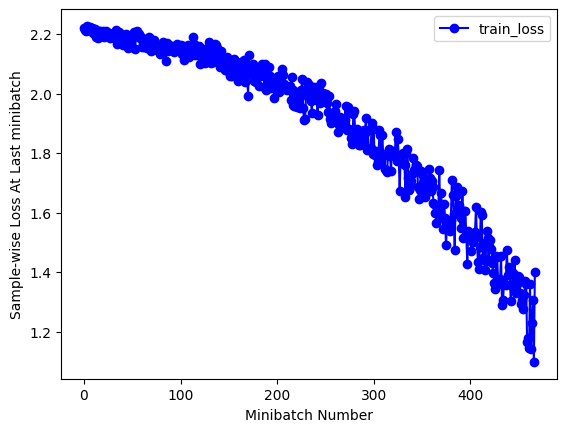

Epoch 2 :
Train accuracy: 81.278336 %
Train loss: 0.005081
Test accuracy: 81.709999 %
Test loss: 0.005006
Test accuracy adversarial: 27.799999 %
Test loss adversarial: 0.014726
Elapsed time for epoch: 2.9387078285217285 s
ETA of completion: 0.39182771046956383 minutes



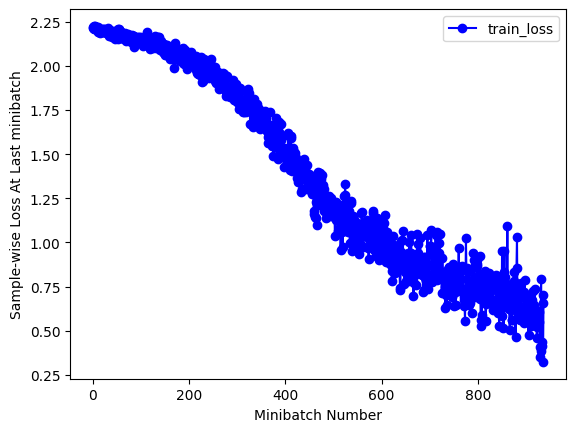

Epoch 3 :
Train accuracy: 85.713333 %
Train loss: 0.003855
Test accuracy: 86.229996 %
Test loss: 0.003761
Test accuracy adversarial: 28.309999 %
Test loss adversarial: 0.015860
Elapsed time for epoch: 2.621603488922119 s
ETA of completion: 0.30585374037424723 minutes



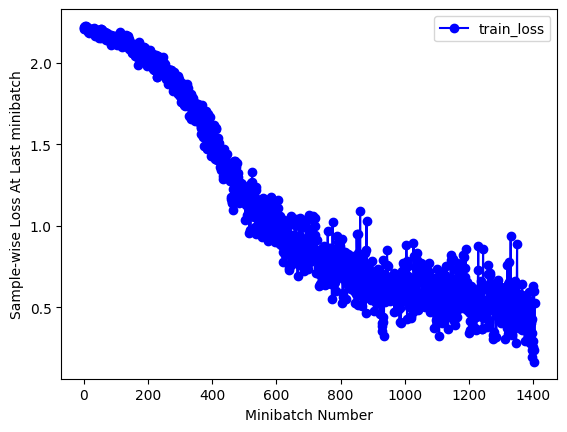

Epoch 4 :
Train accuracy: 87.901665 %
Train loss: 0.003271
Test accuracy: 88.299995 %
Test loss: 0.003185
Test accuracy adversarial: 28.859999 %
Test loss adversarial: 0.016675
Elapsed time for epoch: 2.3290443420410156 s
ETA of completion: 0.23290443420410156 minutes



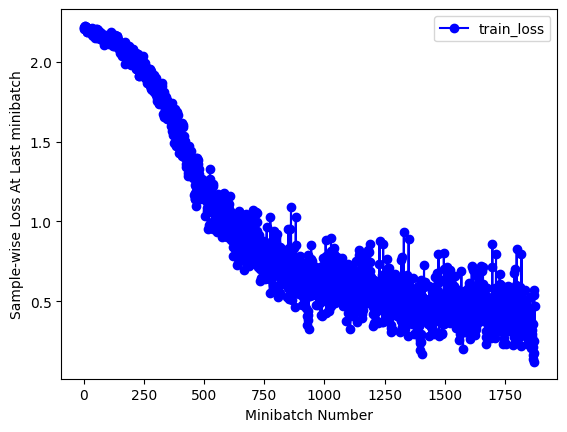

Epoch 5 :
Train accuracy: 89.191666 %
Train loss: 0.002924
Test accuracy: 89.549995 %
Test loss: 0.002853
Test accuracy adversarial: 28.599998 %
Test loss adversarial: 0.017356
Elapsed time for epoch: 2.325589656829834 s
ETA of completion: 0.19379913806915283 minutes



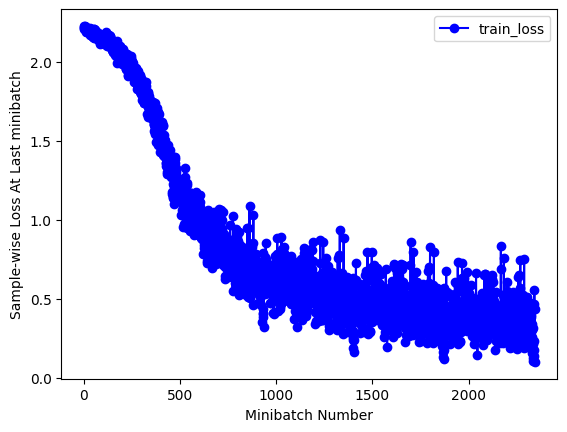

Epoch 6 :
Train accuracy: 90.121666 %
Train loss: 0.002692
Test accuracy: 90.209999 %
Test loss: 0.002631
Test accuracy adversarial: 28.179998 %
Test loss adversarial: 0.017892
Elapsed time for epoch: 2.3383712768554688 s
ETA of completion: 0.15589141845703125 minutes



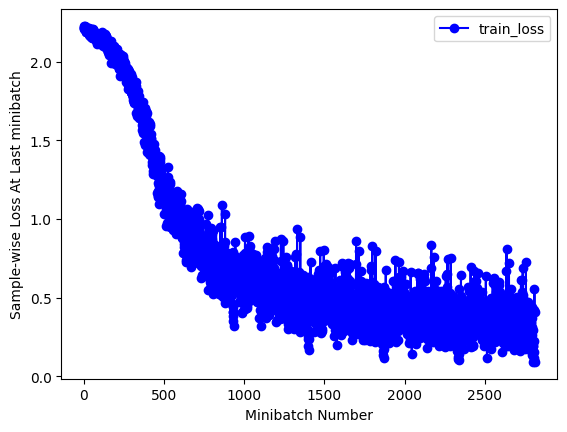

Epoch 7 :
Train accuracy: 90.739998 %
Train loss: 0.002516
Test accuracy: 90.779999 %
Test loss: 0.002462
Test accuracy adversarial: 27.939999 %
Test loss adversarial: 0.018315
Elapsed time for epoch: 3.031460762023926 s
ETA of completion: 0.1515730381011963 minutes



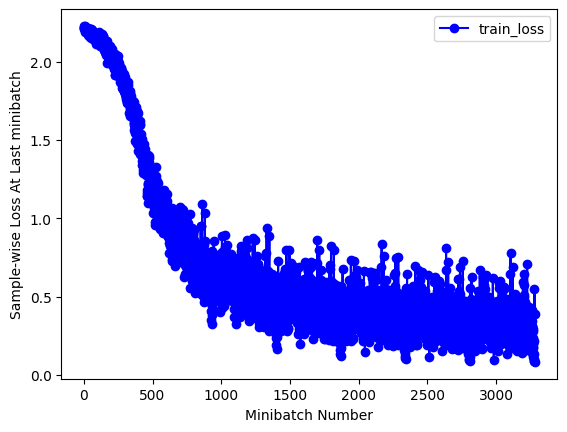

Epoch 8 :
Train accuracy: 91.239998 %
Train loss: 0.002371
Test accuracy: 91.449997 %
Test loss: 0.002324
Test accuracy adversarial: 27.650000 %
Test loss adversarial: 0.018645
Elapsed time for epoch: 2.6601738929748535 s
ETA of completion: 0.08867246309916178 minutes



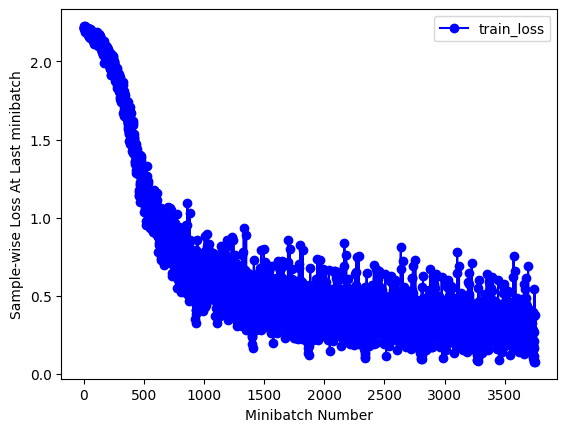

Epoch 9 :
Train accuracy: 91.665001 %
Train loss: 0.002245
Test accuracy: 91.930000 %
Test loss: 0.002205
Test accuracy adversarial: 27.129999 %
Test loss adversarial: 0.018943
Elapsed time for epoch: 2.3149499893188477 s
ETA of completion: 0.038582499821980795 minutes



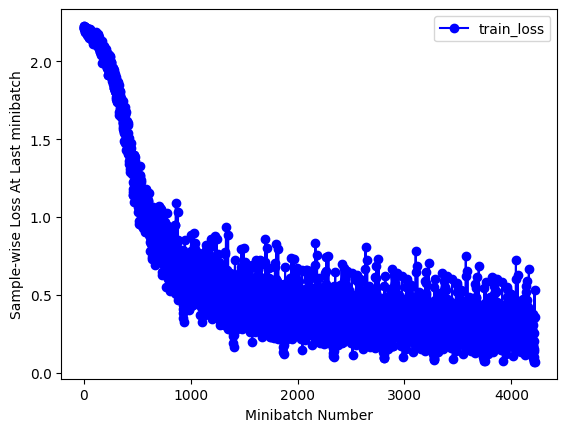

Epoch 10 :
Train accuracy: 92.158333 %
Train loss: 0.002133
Test accuracy: 92.269997 %
Test loss: 0.002099
Test accuracy adversarial: 26.679998 %
Test loss adversarial: 0.019226
Elapsed time for epoch: 2.3153388500213623 s
ETA of completion: 0.0 minutes



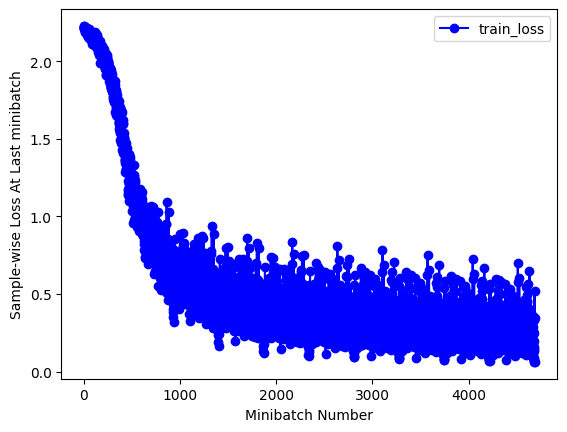

In [ ]:
#number of epochs to train for:
epochs = 10

#define batch train loss recording array for later visualization/plotting:
loss_batch_store = []

print("Starting Training")
#training loop:
for epoch in range(epochs):
    time1 = time.time() #timekeeping

    for i, (x,y) in enumerate(train_loader):

        if gpu_boole:
          x = x.cuda()
          y = y.cuda()

        x = x.view(x.shape[0],-1)

        #loss calculation and gradient update:

        if i > 0 or epoch > 0:
            optimizer.zero_grad()
        outputs = net.forward(x)
        loss = loss_metric(outputs,y)
        loss.backward()

        if i > 0 or epoch > 0:
            loss_batch_store.append(loss.cpu().data.numpy().item())

        ##perform update:
        optimizer.step()

    print("Epoch",epoch+1,':')
    train_perc, train_loss = train_eval()
    test_perc, test_loss = test_eval()
    test_eval_adv()

    time2 = time.time() #timekeeping
    print('Elapsed time for epoch:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
    print()

    ## Plot batch-wise train loss curve:
    plt.plot(loss_batch_store, '-o', label = 'train_loss', color = 'blue')
    plt.xlabel('Minibatch Number')
    plt.ylabel('Sample-wise Loss At Last minibatch')
    plt.legend()
    plt.show()

Visualize Some Examples

Visualize a original Image and its corresponding adversarial example.

Print the prediction of the model for both of the images.

The adversarial sample should look similar to the original image and be easily and correctly classified by a human.

tensor([3], device='cuda:0')


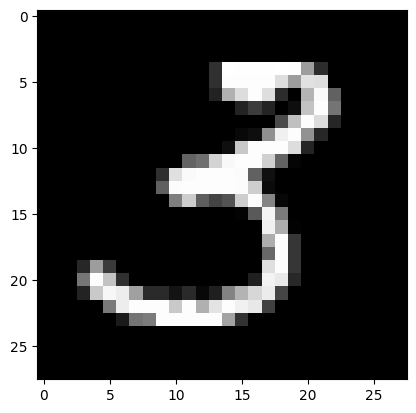

In [ ]:
plt.imshow(x[0].cpu().reshape(28,28),cmap='gray')
print(net(x[0].view(-1,784)).argmax(dim=1))

tensor(5, device='cuda:0')


<ipython-input-6-646958dbd934>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  calculated_loss = self.loss(output, torch.tensor(y_true))


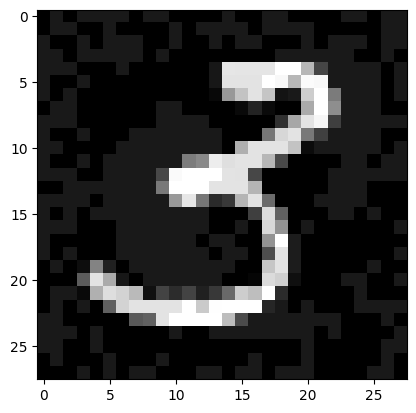

In [ ]:
labels = net(x[0].view(-1,784)).argmax(dim=1)
in_x = Variable(x[[0]], requires_grad=True)
adv_x = adv_attack.forward(in_x, labels, net)
plt.imshow(adv_x[0].detach().cpu().reshape(28,28),cmap='gray')
print(net(adv_x[0].view(-1,784)).argmax(dim=1)[0])

### Part 2: CIFAR Attack

Now, you will attempt to use the same type of adversarial attack against a CIFAR classifier. You should use code structured similarly to that from above. We provide some struture below to get you started. We recommend trying the resnet50 model to begin, but feel free to experiment with model architectures and hyperparameters.

In [3]:
import torch
import torchvision
from torchvision.models import vgg16, resnet50
import torchvision.transforms as transforms

In [4]:
## Transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize(64)])

## Batch Size
batch_size = 128

## Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
## Evaluation Functions (E.g Loss, Accuracy)
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in trainloader:
      if gpu_boole:
          images, labels = images.cuda(), labels.cuda()
      #images = images.view(-1, 3, 32, 32)
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted.float() == labels.float()).sum()

      loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Train accuracy: %f %%' % (100.0 * correct / total))
        print('Train loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in testloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        #images = images.view(-1, 3, 32, 32)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy: %f %%' % (100.0 * correct / total))
        print('Test loss: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total

def test_eval_adv(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    for images, labels in testloader:
        if gpu_boole:
            images, labels = images.cuda(), labels.cuda()
        #images = images.view(-1, 3, 32, 32)
        images = Variable(images, requires_grad=True)
        images = adv_attack.forward(images, Variable(labels), net)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.float() == labels.float()).sum()

        loss_sum += loss_metric(outputs,labels).item()

    if verbose:
        print('Test accuracy adversarial: %f %%' % (100.0 * correct / total))
        print('Test loss adversarial: %f' % (loss_sum / total))

    return 100.0 * correct / total, loss_sum / total




In [10]:
## Helper
def initialize_model(use_resnet=True, pretrained=False, nclasses=10):
    """

    """
    ## Initialize Model
    if use_resnet:
        model = resnet50(pretrained=pretrained)
    else:
        model = vgg16(pretrained=True)
    ## Freeze Early Layers if Pretrained
    if pretrained:
        for parameter in model.parameters():
            parameter.requires_grad = False
    ## Update Output Layer
    if use_resnet:
        model.fc = nn.Linear(2048, nclasses)
    else:
        model.classifier._modules['6'] = nn.Linear(4096, nclasses)
    return model

## Get Model
net = initialize_model(True, False, 10)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01)
loss_metric = nn.CrossEntropyLoss()
## Initialize The Attack
adv_attack = GradientAttack(loss_metric, 0.1)
if gpu_boole:
  net.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### TODO: Train the model using the same structure as before

Starting Training


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 :
Train accuracy: 43.098000 %
Train loss: 0.012064
Test accuracy: 43.309998 %
Test loss: 0.012256


<ipython-input-7-7ec2ce38bbe9>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  calculated_loss = self.loss(output, torch.tensor(y_true))


Test accuracy adversarial: 9.950000 %
Test loss adversarial: 0.022558
Elapsed time for epoch: 154.08705353736877 s
ETA of completion: 23.113058030605316 minutes


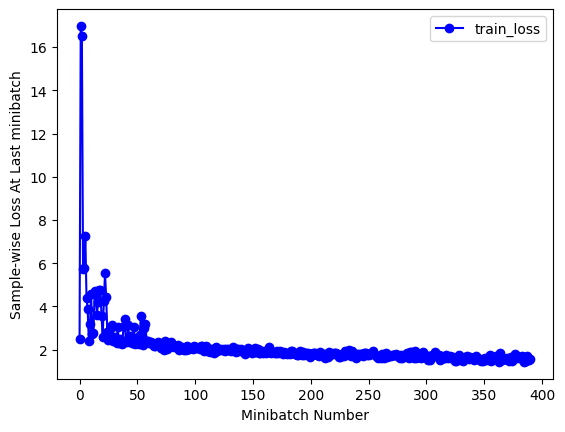

Epoch 2 :
Train accuracy: 54.371998 %
Train loss: 0.009980
Test accuracy: 53.160000 %
Test loss: 0.010350
Test accuracy adversarial: 8.750000 %
Test loss adversarial: 0.025450
Elapsed time for epoch: 151.65919494628906 s
ETA of completion: 20.22122599283854 minutes


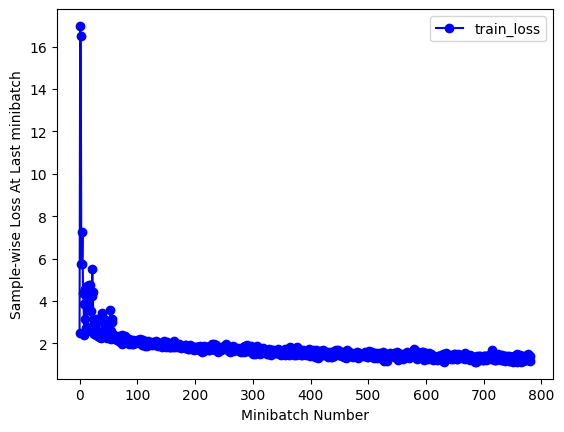

Epoch 3 :
Train accuracy: 62.059998 %
Train loss: 0.008344
Test accuracy: 60.029999 %
Test loss: 0.008887
Test accuracy adversarial: 10.670000 %
Test loss adversarial: 0.027176
Elapsed time for epoch: 152.51798129081726 s
ETA of completion: 17.79376448392868 minutes


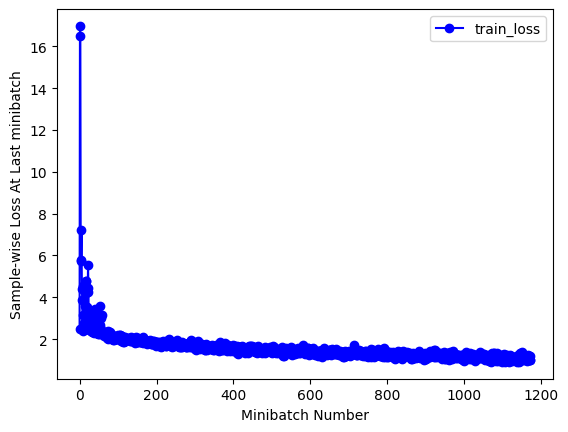

Epoch 4 :
Train accuracy: 65.265999 %
Train loss: 0.007695
Test accuracy: 62.379997 %
Test loss: 0.008379
Test accuracy adversarial: 12.230000 %
Test loss adversarial: 0.027834
Elapsed time for epoch: 151.91733765602112 s
ETA of completion: 15.191733765602113 minutes


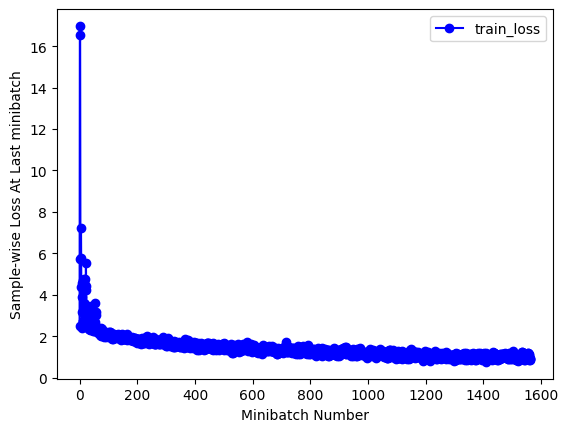

Epoch 5 :
Train accuracy: 72.131996 %
Train loss: 0.006217
Test accuracy: 68.209999 %
Test loss: 0.007197
Test accuracy adversarial: 13.360000 %
Test loss adversarial: 0.029100
Elapsed time for epoch: 151.46302890777588 s
ETA of completion: 12.62191907564799 minutes


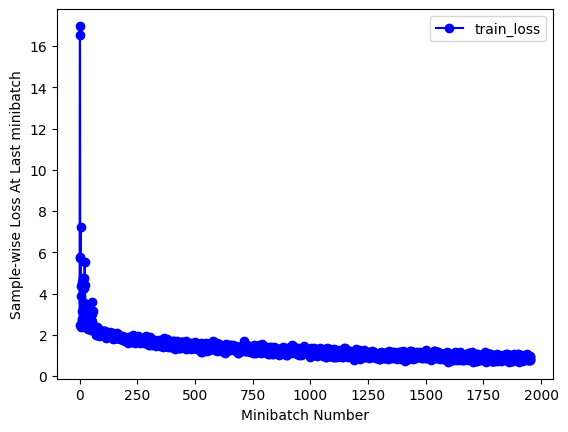

Epoch 6 :
Train accuracy: 76.040001 %
Train loss: 0.005296
Test accuracy: 70.729996 %
Test loss: 0.006686
Test accuracy adversarial: 15.280000 %
Test loss adversarial: 0.028988
Elapsed time for epoch: 154.20250821113586 s
ETA of completion: 10.280167214075725 minutes


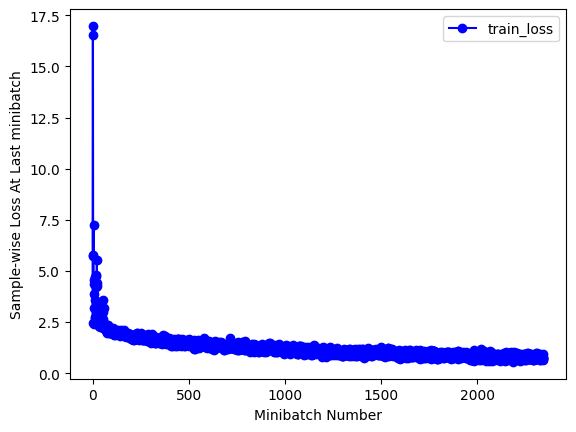

Epoch 7 :
Train accuracy: 78.442001 %
Train loss: 0.004789
Test accuracy: 71.549995 %
Test loss: 0.006447
Test accuracy adversarial: 16.879999 %
Test loss adversarial: 0.029477
Elapsed time for epoch: 155.52244400978088 s
ETA of completion: 7.776122200489044 minutes


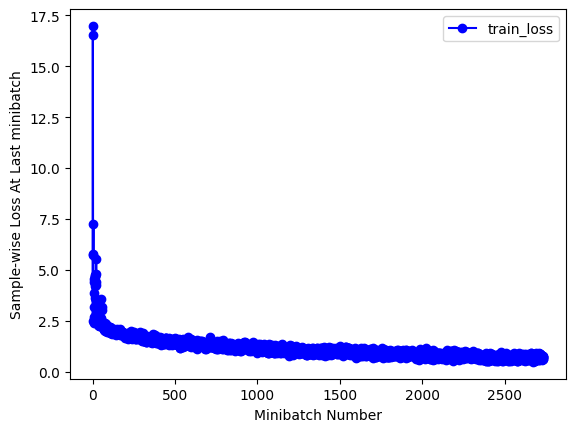

Epoch 8 :
Train accuracy: 81.645996 %
Train loss: 0.004093
Test accuracy: 73.129997 %
Test loss: 0.006199
Test accuracy adversarial: 16.990000 %
Test loss adversarial: 0.031800
Elapsed time for epoch: 153.88124060630798 s
ETA of completion: 5.1293746868769325 minutes


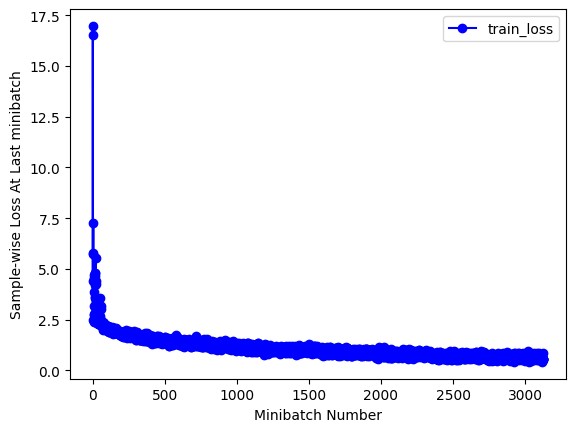

Epoch 9 :
Train accuracy: 83.877998 %
Train loss: 0.003649
Test accuracy: 74.619995 %
Test loss: 0.005978
Test accuracy adversarial: 17.510000 %
Test loss adversarial: 0.032702
Elapsed time for epoch: 152.59409046173096 s
ETA of completion: 2.5432348410288492 minutes


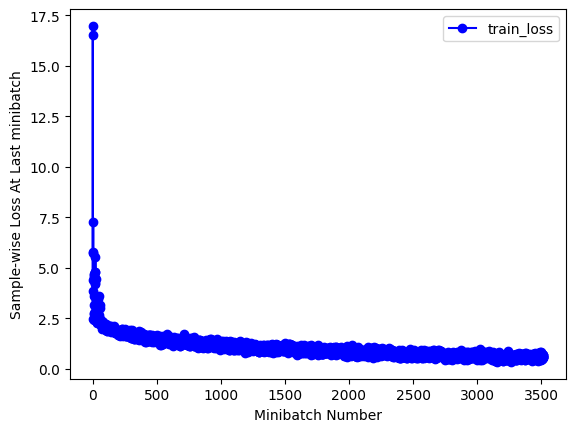

Epoch 10 :
Train accuracy: 87.113998 %
Train loss: 0.002985
Test accuracy: 75.449997 %
Test loss: 0.005792
Test accuracy adversarial: 17.820000 %
Test loss adversarial: 0.033603
Elapsed time for epoch: 151.1497311592102 s
ETA of completion: 0.0 minutes


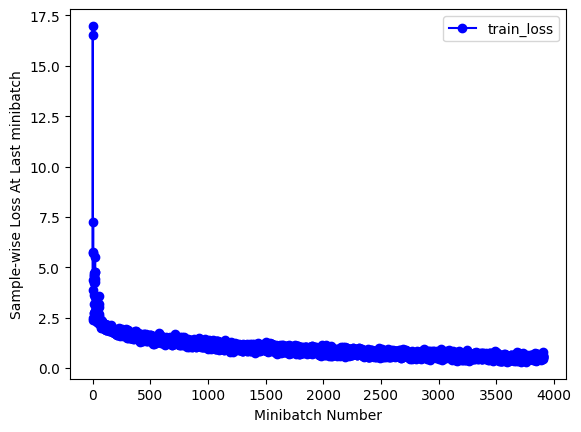

In [11]:
# Number of epochs to train for
epochs = 10

# Define batch train loss recording array for later visualization/plotting
loss_batch_store = []

print("Starting Training")

# Training loop
for epoch in range(epochs):
    time1 = time.time()  # Timekeeping

    for i, (x, y) in enumerate(trainloader):
        x, y = x.cuda(), y.cuda()
        x.requires_grad = True  # Ensure the input tensor requires gradients

        optimizer.zero_grad()

        # Forward pass
        outputs = net(x)
        loss = loss_metric(outputs, y)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Record loss
        loss_batch_store.append(loss.item())

    print("Epoch", epoch + 1, ':')
    train_perc, train_loss = train_eval()
    test_perc, test_loss = test_eval()
    test_eval_adv()


    time2 = time.time()  # Timekeeping
    print('Elapsed time for epoch:', time2 - time1, 's')
    print('ETA of completion:', (time2 - time1) * (epochs - epoch - 1) / 60, 'minutes')

    # Plot batch-wise train loss curve
    plt.plot(loss_batch_store, '-o', label='train_loss', color='blue')
    plt.xlabel('Minibatch Number')
    plt.ylabel('Sample-wise Loss At Last minibatch')
    plt.legend()
    plt.show()

In [163]:
# Function to generate and visualize adversarial examples
def visualize_adversarial_examples(model, testloader):
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        images.requires_grad = True

        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        data_grad = images.grad.data

        perturbed_images = adv_attack.forward(images, labels, net)

       # Show original and adversarial images
        num_images = 2
        rows = num_images // 2  # Two images per row
        plt.figure(figsize=(8, 8))
        for i in range(num_images):
            plt.subplot(rows, 4, i * 2 + 1)
            plt.tight_layout()
            original_image = images[i].cpu().detach().numpy().transpose((1, 2, 0))
            plt.imshow(original_image)
            plt.title("Original: {}".format(testset.classes[labels[i]]))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(rows, 4, i * 2 + 2)
            plt.tight_layout()
            adversarial_image = perturbed_images[i].cpu().detach().numpy().transpose((1, 2, 0))
            plt.imshow(adversarial_image)
            plt.title("Adversarial: {}".format(testset.classes[labels[i]]))
            plt.xticks([])
            plt.yticks([])

        plt.show()
        break  # Show only one batch of images for demonstration

<ipython-input-7-7ec2ce38bbe9>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  calculated_loss = self.loss(output, torch.tensor(y_true))


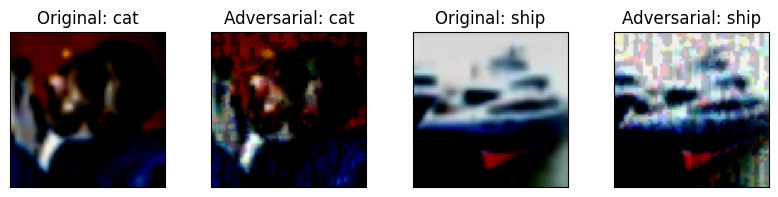

In [164]:
visualize_adversarial_examples(net, testloader)

### Part 3: Real World Example

Use your phone or other camera device to take a picture of an item you would find in CIFAR-10. Upload the photo to this notebook and format it so that it can be analyzed by your image classifier and the adversarial example generator.

In [214]:
## Complete your work below
## Mount Google Drive Data (If using Google Colaboratory)
from torchvision import transforms
from PIL import Image
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

data_path = "/content/gdrive/MyDrive/Colab Notebooks/MLDL_HW7/Real_World_Cat_CIFAR10.jpg"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [224]:
# Load the image
img = Image.open(data_path)

# Apply transformations
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Preprocess the image
input_img = preprocess(img).unsqueeze(0)  # Add batch dimension

<ipython-input-7-7ec2ce38bbe9>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  calculated_loss = self.loss(output, torch.tensor(y_true))


Text(0.5, 1.0, 'Generated, Pred_label: cat')

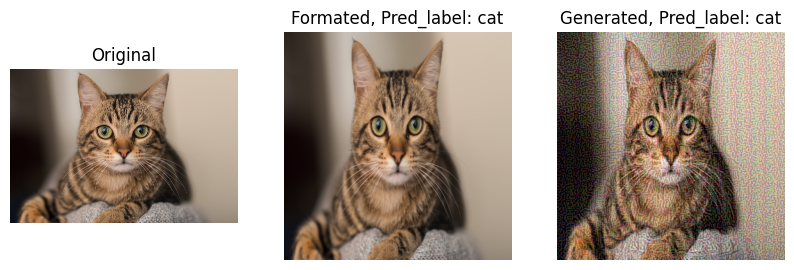

In [229]:
class_labels = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
input_img = input_img.cuda()
label = torch.tensor([4]).cuda()
input_img.requires_grad = True

output = net(input_img)
loss = torch.nn.functional.cross_entropy(output, label)
net.zero_grad()
loss.backward()
data_grad = input_img.grad.data
perturbed_images = adv_attack.forward(input_img, label, net)

# Assuming output is a tensor of predictions, you can extract the predicted class
_, predicted = torch.max(output, 1)
predicted_label_index = predicted.item()
gen_output = net(perturbed_images.cuda())
_, gen_predicted = torch.max(gen_output, 1)
gen_predicted_label_index = predicted.item()

# Match the predicted label index with your labels list
predicted_label = class_labels[predicted_label_index]
gen_predicted_label = class_labels[gen_predicted_label_index]



fig, axes = plt.subplots(1, 3, figsize=(10, 10))
# Show the image in the ith subplot
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Original")
axes[1].imshow(input_img.cpu().squeeze().detach().numpy().transpose((1, 2, 0)))
axes[1].axis('off')
axes[1].set_title(f"Formated, Pred_label: {predicted_label}")
axes[2].imshow(perturbed_images.cpu().squeeze().detach().numpy().transpose((1, 2, 0)))
axes[2].axis('off')
axes[2].set_title(f"Generated, Pred_label: {gen_predicted_label}")
